In [1]:
import numpy as np
import torch
from datasets.mbes import MBESDataset
from models.denoise import DenoiseNet
from utils.transforms import *
from utils.denoise import patch_based_denoise
import os
import pytorch3d
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

In [2]:
raw_data_root = 'data/mbes-denoising/gullmarsfjord-190618-svp+30/raw_patches_32pings_400beams'
gt_root = 'data/mbes-denoising/gullmarsfjord-190618-svp+30/draping_.5m_patches_32pings_400beams'
split = 'tmp-val' # validation set
# split = 'tmp' # training set
val_dset = MBESDataset(
    raw_data_root=raw_data_root,
    gt_root=gt_root,
    split=split,
    transform=Compose([
        # NormalizeNoisyToUnitSphere(),
        # AddNoiseToZ(.005, .02)
        NormalizeZ(),
        ]),
)

#ckpt_path = 'logs/MBES_patches2024_04_29__22_31_02_norm-noisy/ckpt_1.541353_1500.pt'
# ckpt_path = 'logs/MBES_patches2024_04_30__17_25_42_norm-noisy-knnxy/ckpt_0.051991_200.pt'
# ckpt_path = 'logs/MBES_patches2024_04_30__17_25_42_norm-noisy-knnxy/ckpt_0.038366_400.pt'
# ckpt_path = 'logs/MBES_patches2024_04_30__17_25_42_norm-noisy-knnxy/ckpt_0.004513_3200.pt'
# ckpt_path = 'logs/MBES_patches2024_05_01__16_58_23_norm-noisy-knnxy-large-neighbors-+noiseZ/ckpt_0.000532_800.pt'
# ckpt_path = 'logs/MBES_patches2024_05_01__17_10_11_norm-noisy-knnxy-large-neighbors-+noiseZ/ckpt_0.001328_100.pt'
ckpt_path = 'logs/MBES_patches2024_05_06__16_37_42_norm-z/ckpt_0.002273_1200.pt'
ckpt = torch.load(ckpt_path)
device = ckpt['args'].device
model = DenoiseNet(ckpt['args']).to(device)
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [3]:
# index = -5
index = 5
traj = []
data = val_dset[index]
pcl_noisy = data['pcl_noisy'].reshape(-1, 3).to(device)
pcl_clean = data['pcl_clean'].reshape(-1, 3).to(device)
pcl_denoised, traj = patch_based_denoise(model, pcl_noisy,
                                   denoise_knn=64,
                                   ld_step_size=0.2,
                                   ld_num_steps=20,
                                   get_traj=True,)

pcl_denoised: torch.Size([12800, 3])


pcl clean mean: -0.763, min: -0.997, max: -0.652
pcl noisy mean: -0.749, min: -0.997, max: 1.000
pcl denoised mean: -0.769, min: -0.999, max: -0.651
Num raw points z_diff > 50% max: 91
raw z_diff: 0.013, min: -0.085, max: 1.775
denoised z_diff: -0.007, min: -0.088, max: 0.099


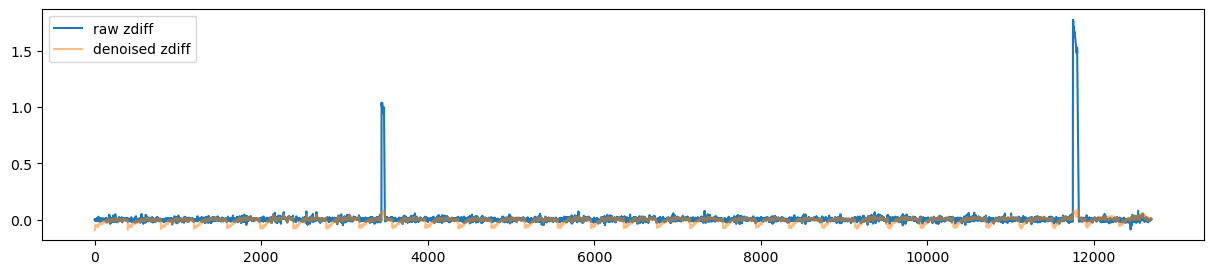

In [4]:
valid_mask = data['valid_mask']
pcl_noisy_subset = pcl_noisy.view(32, 400, 3)[valid_mask]
# pcl_noisy_subset = pcl_noisy
raw_z_diff = pcl_noisy_subset[:, 2] - pcl_clean[:, 2]
pcl_denoised_subset = pcl_denoised.view(32, 400, 3)[valid_mask]
#pcl_denoised_subset = pcl_denoised
denoised_z_diff = pcl_denoised_subset[:, 2] - pcl_clean[:, 2]
print(f'pcl clean mean: {pcl_clean[:, 2].mean():.3f}, min: {pcl_clean[:, 2].min():.3f}, max: {pcl_clean[:, 2].max():.3f}')
print(f'pcl noisy mean: {pcl_noisy_subset[:, 2].mean():.3f}, min: {pcl_noisy_subset[:, 2].min():.3f}, max: {pcl_noisy_subset[:, 2].max():.3f}')
print(f'pcl denoised mean: {pcl_denoised_subset[:, 2].mean():.3f}, min: {pcl_denoised_subset[:, 2].min():.3f}, max: {pcl_denoised_subset[:, 2].max():.3f}')
print(f'Num raw points z_diff > 50% max: {(raw_z_diff > 0.5*raw_z_diff.max()).sum()}')
print(f'raw z_diff: {raw_z_diff.mean():.3f}, min: {raw_z_diff.min():.3f}, max: {raw_z_diff.max():.3f}')
print(f'denoised z_diff: {denoised_z_diff.mean():.3f}, min: {denoised_z_diff.min():.3f}, max: {denoised_z_diff.max():.3f}')
plt.figure(figsize=(15, 3))
plt.plot(raw_z_diff.cpu().numpy(), label='raw zdiff')
plt.plot(denoised_z_diff.cpu().numpy(), label='denoised zdiff', alpha=0.5)
plt.legend()

torch.Size([12692, 3])
torch.Size([1, 12692, 3])


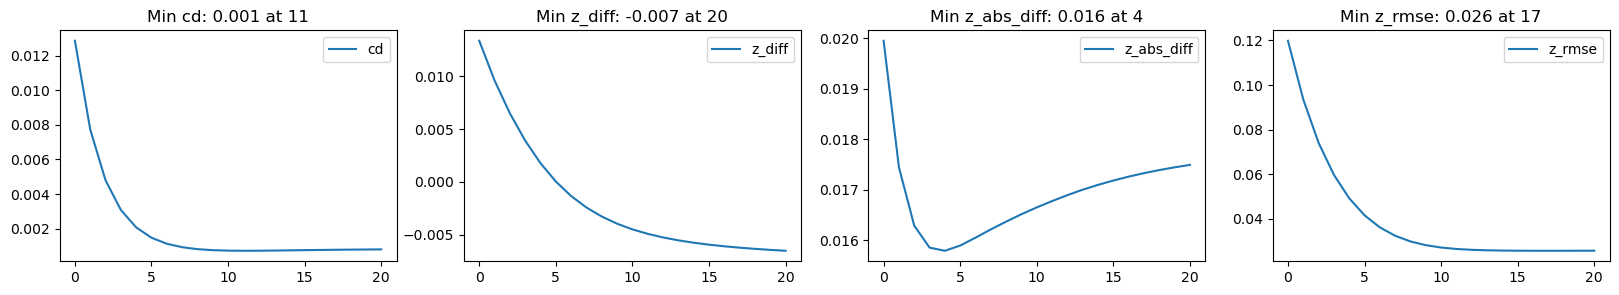

In [5]:
def compute_metrics(t, pcl_ref, valid_mask):
    t = t.unsqueeze(0).to(device)
    cd = pytorch3d.loss.chamfer_distance(t,
                                        pcl_ref,
                                        point_reduction='mean')[0].item()

    t_masked = t.view(32, 400, 3)[valid_mask]
    pcl_ref = pcl_ref.reshape(t_masked.shape)
    z_diff = (t_masked[:, 2] - pcl_ref[:, 2]).mean().item()
    z_abs_diff = (t_masked[:, 2] - pcl_ref[:, 2]).abs().mean().item()
    z_rmse = torch.sqrt((t_masked[:, 2] - pcl_ref[:, 2]).pow(2).mean()).item()
    return {'cd': cd, 'z_diff': z_diff, 'z_abs_diff': z_abs_diff, 'z_rmse': z_rmse}

from collections import defaultdict
traj_metrics = defaultdict(list)

pcl_ref = pcl_clean.unsqueeze(0).to(device)
print(pcl_clean.shape)
print(pcl_ref.shape)
for i, t in enumerate(traj):
    metrics = compute_metrics(t, pcl_ref, valid_mask)
    for k, v in metrics.items():
        traj_metrics[k].append(v)

num_plots = len(traj_metrics.keys())
fig, ax = plt.subplots(1, num_plots, figsize=(5*num_plots, 3))
for i, (k, v) in enumerate(traj_metrics.items()):
    v = np.array(v)
    ax[i].plot(v, label=k)
    ax[i].legend()
    title = f'Min {k}: {v.min():.3f} at {np.argmin(v)}'
    ax[i].set_title(title)

Text(0.5, 0.98, 'Denoising results')

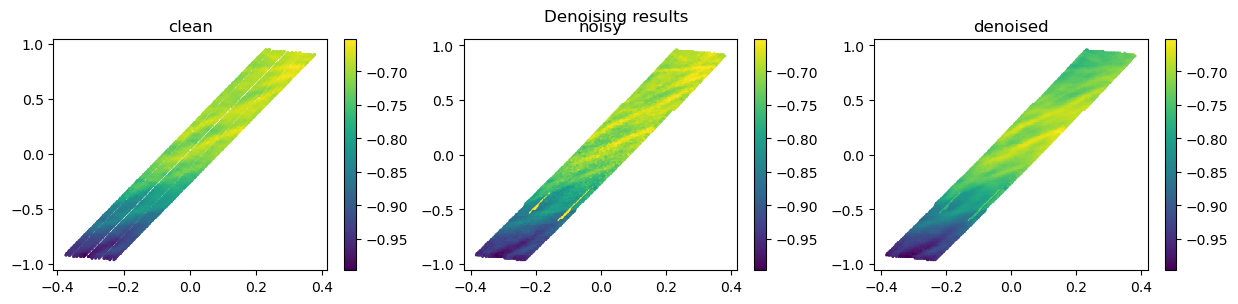

In [6]:
def plot_pcl(pcl, ax, title=None, vmin=None, vmax=None):
    if vmin is None:
        vmin = pcl[:, 2].min()
    if vmax is None:
        vmax = pcl[:, 2].max()
    plt.colorbar(
        ax.scatter(pcl[:, 0], pcl[:, 1], s=1, c=pcl[:, 2], cmap='viridis',
                   vmin=vmin, vmax=vmax),
        ax=ax
    )
    if title:
        ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))#, sharex=True, sharey=True)
pcl_names = ['clean', 'noisy', 'denoised']
pcls = {
    'clean': pcl_clean.cpu(),
    'noisy': pcl_noisy.cpu(),
    'denoised': pcl_denoised.cpu(),
}
vmin = pcls['clean'][:, 2].min()
vmax = pcls['clean'][:, 2].max()
for i, ax in enumerate(axes):
    name = pcl_names[i]
    pcl = pcls[name]
    plot_pcl(pcl, ax, name
    # )
             , vmin=vmin, vmax=vmax)
plt.suptitle('Denoising results')

Text(0.5, 0.98, 'Denoising trajectory')

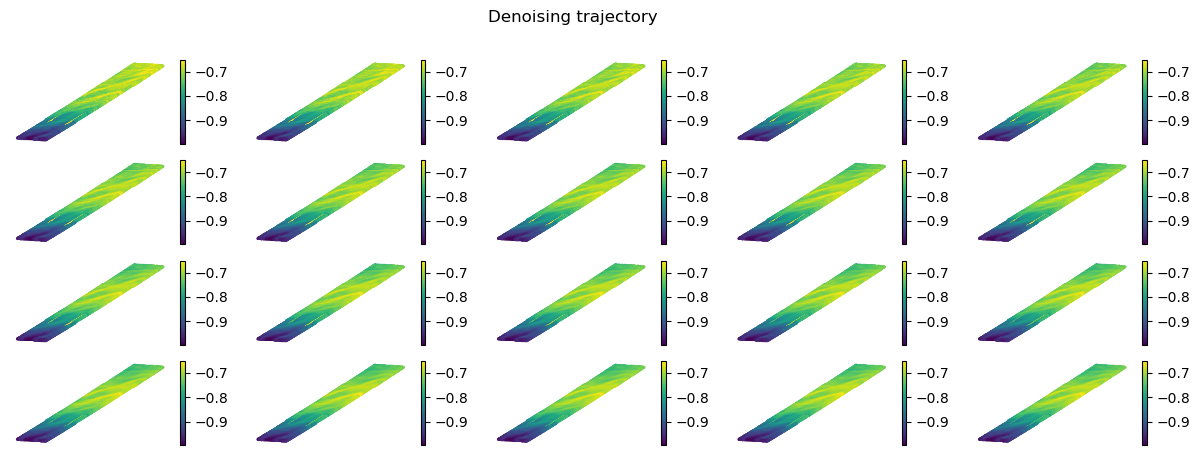

In [7]:
num_traj = len(traj)
num_cols = 5
num_rows = num_traj // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5), sharex=True, sharey=True)

for i, row_ax in enumerate(axes):
    for j, ax in enumerate(row_ax):
        ax.axis('off')
        traj_idx = i * num_cols + j
        plot_pcl(traj[traj_idx], ax, vmin=vmin, vmax=vmax)
plt.suptitle('Denoising trajectory')